In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt

import aptwrapper

# Nanodrop

All samples have approx similar protein concentrations. (If they were lysozyme, that would be 10-20 mg/mL)

In [2]:
data_nanodrop = (
    pd.read_csv('./2023_08_23_Protein A280_1.csv', sep=';')
    .drop(columns=['#', 'User name', 'Date and Time'])
    .drop_duplicates(subset='Sample ID', keep='first')
    .apply(axis=1, func=lambda df: pd.Series(dict(
        sample_id=df['Sample ID'],
        condition=df['Sample ID'][0],
        rep_t=(int(df['Sample ID'][1:])-1)%3+1,
        rep_b=(int(df['Sample ID'][1:])-1)//3+1,
        mass_mgml=df['Protein']/1000,
        a280=df['A280 (Abs)']/1000,
        a260_280=df['260/280']/100,
    )))
)

data_nanodrop

,sample_id,condition,rep_t,rep_b,mass_mgml,a280,a260_280
0,B1,B,1,1,10.439,6.994,1.30
1,H1,H,1,1,11.012,7.378,1.30
3,R1,R,1,1,13.754,9.215,1.28
4,B2,B,2,1,13.028,8.729,1.30
6,H2,H,2,1,11.927,7.991,1.31
7,R2,R,2,1,11.721,7.853,1.28
8,B3,B,3,1,13.766,9.223,1.31
9,H3,H,3,1,12.313,8.249,1.33
10,R3,R,3,1,14.088,9.439,1.31
11,B4,B,1,2,16.407,10.993,1.30


[Text(0.5, 1.0, 'A260/A280'), Text(0, 0.5, '')]

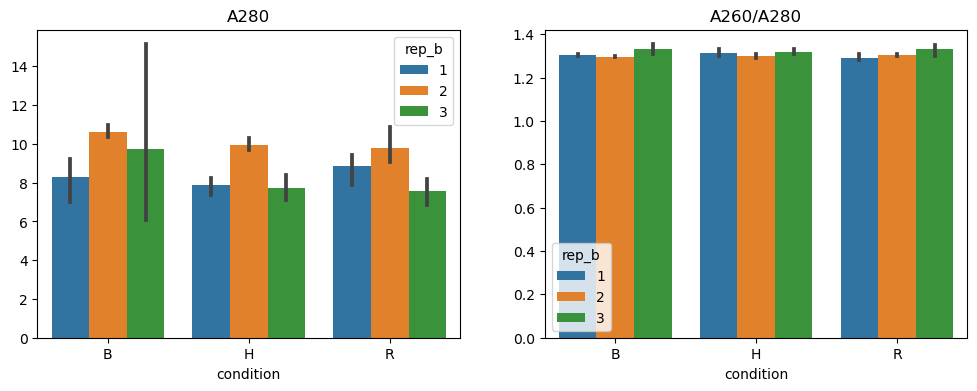

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data_nanodrop, x='condition', y='a280', hue='rep_b', palette='tab10', ax=ax[0])
sns.barplot(data_nanodrop, x='condition', y='a260_280', hue='rep_b', palette='tab10', ax=ax[1])
ax[0].set(title='A280', ylabel='')
ax[1].set(title='A260/A280', ylabel='')

# BCA

All samples have similar protein concentrations.

In [4]:
layout = np.array([
    ['sA1', 'sA2', 'sA3',  'B1',  'B2',  'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9'],
    ['sB1', 'sB2', 'sB3',  'H1',  'H2',  'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9'],
    ['sC1', 'sC2', 'sC3',  'R1',  'R2',  'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9'],
    ['sD1', 'sD2', 'sD3', 'sI1', 'sI2', 'sI3',   '',   '',   '',   '',   '',   ''],
    ['sE1', 'sE2', 'sE3',    '',    '',    '',   '',   '',   '',   '',   '',   ''],
    ['sF1', 'sF2', 'sF3',    '',    '',    '',   '',   '',   '',   '',   '',   ''],
    ['sG1', 'sG2', 'sG3',    '',    '',    '',   '',   '',   '',   '',   '',   ''],
    ['sH1', 'sH2', 'sH3',    '',    '',    '',   '',   '',   '',   '',   '',   ''],
])

layout.shape

(8, 12)

<AxesSubplot:>

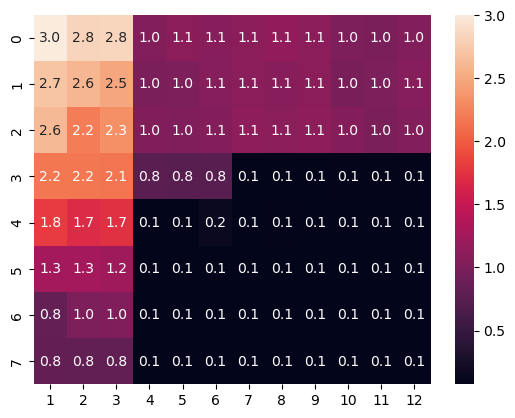

In [5]:
a480 = (
    pd.read_csv('./bca assay 230823.TXT', skiprows=7, sep=';')
    .drop(columns=['Unnamed: 0', 'Unnamed: 13'])
    .applymap(lambda x: float(x.replace(',', '.')))
    # .values
)

# a480.iloc[:3,3:].T.describe()
sns.heatmap(a480, annot=True, fmt='.1f')

# FTIR (dried)

All samples have identical FTIR spectra

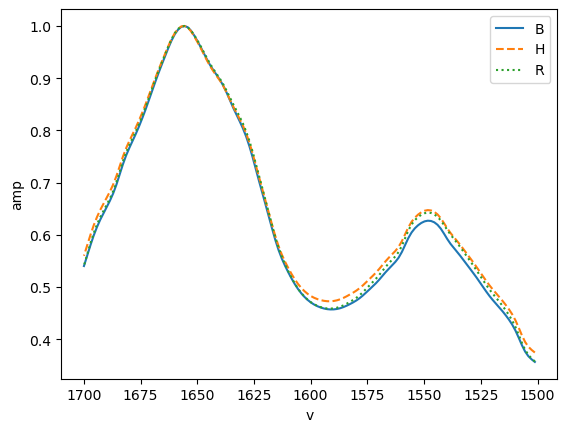

In [6]:
from os import listdir

path = './htx-trans/'

positions = [f'C{i}' for i in range(10,13)] + [f'D{i}' for i in range(1,13)] + [f'E{i}' for i in range(1,13) if i != 11] + [f'F{i}' for i in range(1,5)] 
samples = [f'{c}{i}' for i in range(1,10) for c in 'BHR'] + ['blank1', 'blank2', 'blank3']

def read_file(sample, position):
    df = pd.read_csv(f'{path}{20230825}_{position}.0.dpt', sep='\t', names=['v', 'amp'])
    return xr.DataArray(data=df.amp, dims=['v'], coords={'v': df.v, 'sample': sample})

data = xr.concat([read_file(s, p) for s, p in zip(samples, positions)], dim='sample')
data = data.sortby(data.v)
blank = data.isel(sample=data.sample.str.startswith('blank')).mean(dim='sample')
data = data.isel(sample=~data.sample.str.startswith('blank')) - blank
data = data.assign_coords(
    condition = data.sample.str[0],
    replicate = data.sample.str[1:].astype(int),
)

data = data / data.sel(v=slice(1500,1800)).max(dim='v')
data = data.groupby('condition').mean()

for s in data:
    # c = f'C{s.replicate.item()}'
    styles = dict(B='-', H='--', R=':')
    s.sel(v=slice(1500,1700)).plot( ls=styles[s.condition.item()], label=s.condition.item())

plt.legend()
plt.title('')
plt.gca().invert_xaxis()

# TEM

See data folder. The samples contain some non-lysed bacteria. The H sample has some IBs (?).

# AFM-IR

**Doesn't contain data from 23-10-04!!!**

In [7]:
doc_h1  = aptwrapper.read('./2023-09-15 AFM-IR/230230915_h1.axz')
doc_r1  = aptwrapper.read('./2023-09-15 AFM-IR/230230918_r1.axz')
doc_b1  = aptwrapper.read('./2023-09-15 AFM-IR/230230919_b1.axz')
doc_b4  = aptwrapper.read('./2023-09-15 AFM-IR/20231004_b4.axz')
doc_h4a = aptwrapper.read('./2023-09-15 AFM-IR/20231004_h4_sessionA.axz')
doc_h4b = aptwrapper.read('./2023-09-15 AFM-IR/20231004_h4_sessionB.axz')
doc_r4  = aptwrapper.read('./2023-09-15 AFM-IR/20231004_r4.axz')
doc_b7  = aptwrapper.read('./2023-09-15 AFM-IR/20231005_b7.axz')
doc_h7  = aptwrapper.read('./2023-09-15 AFM-IR/20231005_h7.axz')
doc_r7  = aptwrapper.read('./2023-09-15 AFM-IR/20231005_r7.axz')

<xarray.Dataset>
Dimensions:              (si: 14, v: 176)
Coordinates:
    Label                (si) <U11 'Spectrum 1' 'Spectrum 2' ... 'Spectrum 14'
    Location.X           (si) float64 -177.3 -177.8 -177.4 ... -182.2 -181.9
    Location.Y           (si) float64 -989.9 -989.1 -989.9 ... -993.3 -992.7
    PulseRate            (si) float64 540.0 696.3 541.2 ... 608.3 552.3 608.3
    TimeStamp            (si) datetime64[ns] 2023-09-19T11:57:45.979500400 .....
    AFMMode              <U7 'Contact'
    AttenuationBase64    float64 0.0137
    BackgroundFileName   <U68 'C:\\Users\\nanoIR\\Desktop\\DATA\\Wouter\\2023...
    BackgroundOption     <U6 'Normal'
    Polarization         <U2 '90'
  * v                    (v) float64 1.45e+03 1.452e+03 ... 1.798e+03 1.8e+03
    is_ib                (si) bool True False True False ... False True False
Dimensions without coordinates: si
Data variables:
    IR Phase (Deg)       (si, v) float64 1.17 1.16 1.166 ... -19.39 -31.78
    PLL Frequency (kHz)  (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    IR Amplitude (mV)    (si, v) float64 0.2062 0.2061 0.2079 ... 0.1161 0.1241
    Attenuation          (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Background           (si, v) float64 0.5702 0.5595 ... 0.06144 0.04149

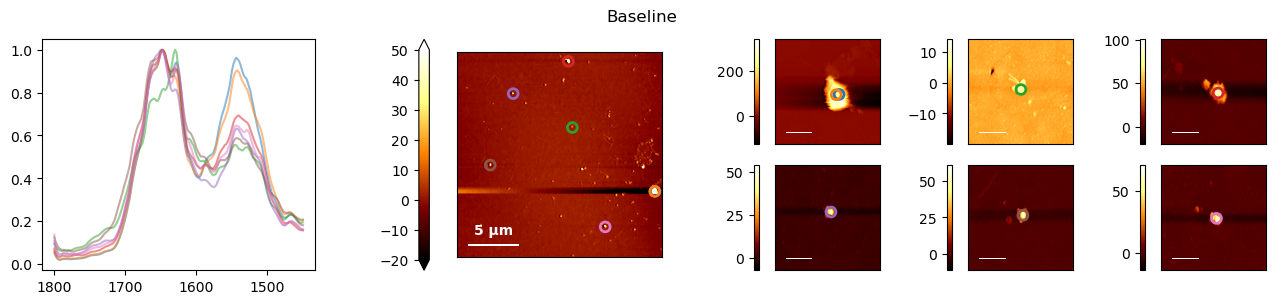

In [9]:
def plot_spectra(spectra, hmap_overview, hmaps_detail):
    fig = plt.figure(figsize=(16,3))
    gs = plt.GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 2])

    map_ax = []

    def plotmap(ax, map, scalebar=True, vmin=None, vmax=None, robust=None):
        aptwrapper.plot_map(map, ax=ax, cb_label='', vmin=vmin, vmax=vmax, robust=robust, show_sb_val=scalebar)
        ax.set(xlim=(map.X.min(), map.X.max()), ylim=(map.Y.min(), map.Y.max()))

    # Plot main map
    ax1 = plt.subplot(gs[1])
    plotmap(ax1, hmap_overview, vmin=-20, vmax=50)
    map_ax += [ax1]

    # Plot detail maps
    n = len(hmaps_detail)
    cols = int(np.ceil(n/2))
    sgs = gs[2].subgridspec(2 if n > 1 else 1, cols)
    for i in range(n):
        ax = plt.subplot(sgs[0,i] if i < cols else sgs[1,i-cols])
        plotmap(ax, hmaps_detail[i], scalebar=False)
        map_ax += [ax]    

    ax0 = plt.subplot(gs[0])
    for i in range(len(spectra.si)):
        ax0.plot(spectra.v, spectra['IR Amplitude (mV)'].sel(si=i), c=f'C{i}', alpha=.5)
        for a in map_ax:
            a.scatter(spectra.sel(si=i)['Location.X'], spectra.sel(si=i)['Location.Y'], ec=f'C{i}', c='None', lw=2, s=50)
    ax0.invert_xaxis()

d = doc_b1
spectra = xr.concat(d.RenderedSpectra.values(), 'si').assign_coords(is_ib=lambda x: x.si % 2 == 0)
spectra = aptwrapper.savgol(spectra)
spectra = spectra / spectra.sel(v=slice(1600,1700)).max('v')
s_ib = spectra.isel(si=spectra.is_ib==True)

plot_spectra(s_ib, d.HeightMaps['Height 3'], [d.HeightMaps[f'Height {i}'] for i in range(4,10)])
plt.suptitle('Baseline')
spectra

<xarray.Dataset>
Dimensions:              (si: 20, v: 176)
Coordinates:
    Label                (si) <U11 'Spectrum 3' 'Spectrum 4' ... 'Spectrum 22'
    Location.X           (si) float64 -1.772e+03 -1.772e+03 ... -1.717e+03
    Location.Y           (si) float64 475.3 476.0 472.2 ... 482.3 482.4 482.9
    PulseRate            (si) float64 539.8 582.2 535.4 ... 605.6 543.3 612.8
    TimeStamp            (si) datetime64[ns] 2023-09-15T15:39:44.411389900 .....
    AFMMode              <U7 'Contact'
    AttenuationBase64    float64 0.0137
    BackgroundFileName   <U68 'C:\\Users\\nanoIR\\Desktop\\DATA\\Wouter\\2023...
    BackgroundOption     <U6 'Normal'
    Polarization         <U2 '90'
  * v                    (v) float64 1.45e+03 1.452e+03 ... 1.798e+03 1.8e+03
    is_ib                (si) bool True False True False ... False True False
Dimensions without coordinates: si
Data variables:
    IR Phase (Deg)       (si, v) float64 1.02 1.019 1.016 ... 1.259 1.297 1.584
    PLL Frequency (kHz)  (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    IR Amplitude (mV)    (si, v) float64 0.4154 0.3073 ... 0.04404 0.03079
    Attenuation          (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Background           (si, v) float64 0.3464 0.4527 0.5152 ... 0.1115 0.1104

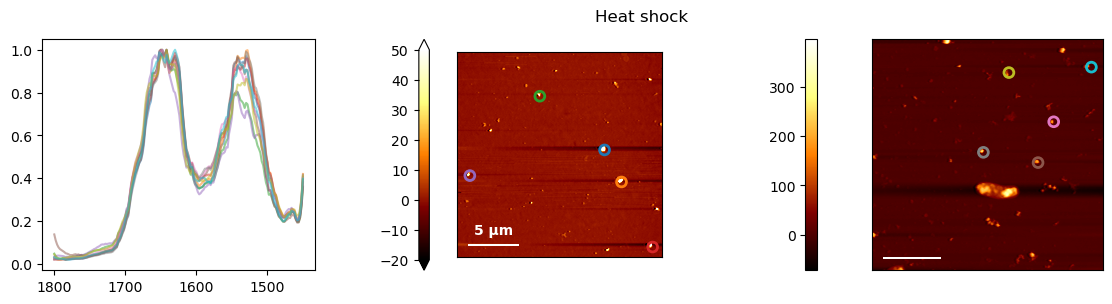

In [10]:
d = doc_h1
spectra = xr.concat(d.RenderedSpectra.values(), 'si').assign_coords(is_ib=lambda x: x.si % 2 == 0)
spectra = aptwrapper.savgol(spectra)
spectra = spectra / spectra.sel(v=slice(1600,1700)).max('v')
s_ib = spectra.isel(si=spectra.is_ib==True)
plot_spectra(s_ib, d.HeightMaps['Height 3'], [d.HeightMaps[f'Height 5']])
plt.suptitle('Heat shock')
spectra

<xarray.Dataset>
Dimensions:              (si: 32, v: 176)
Coordinates:
    Label                (si) <U11 'Spectrum 1' 'Spectrum 2' ... 'Spectrum 34'
    Location.X           (si) float64 89.73 90.03 86.64 ... 99.68 99.64 99.59
    Location.Y           (si) float64 -1.114e+03 -1.114e+03 ... -1.105e+03
    PulseRate            (si) float64 549.0 616.6 536.9 ... 547.3 547.3 547.3
    TimeStamp            (si) datetime64[ns] 2023-09-18T10:35:17.653789500 .....
    AFMMode              <U7 'Contact'
    AttenuationBase64    float64 0.0137
    BackgroundFileName   <U68 'C:\\Users\\nanoIR\\Desktop\\DATA\\Wouter\\2023...
    BackgroundOption     <U6 'Normal'
    Polarization         <U2 '90'
  * v                    (v) float64 1.45e+03 1.452e+03 ... 1.798e+03 1.8e+03
    is_ib                (si) bool True False True False ... False True False
Dimensions without coordinates: si
Data variables:
    IR Phase (Deg)       (si, v) float64 1.727 1.48 1.331 ... 1.084 1.807 3.276
    PLL Frequency (kHz)  (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    IR Amplitude (mV)    (si, v) float64 0.4423 0.2868 ... 0.04959 0.07291
    Attenuation          (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Background           (si, v) float64 0.2837 0.438 0.5303 ... 0.07446 0.06679

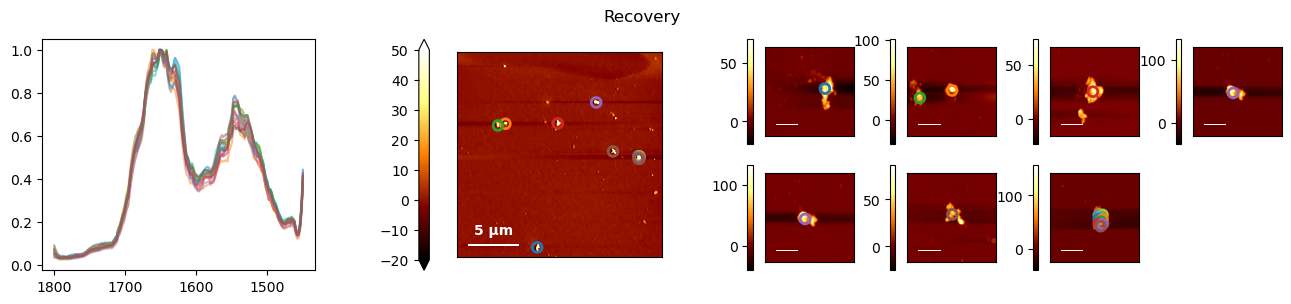

In [11]:
d = doc_r1
spectra = xr.concat(d.RenderedSpectra.values(), 'si').assign_coords(is_ib=lambda x: x.si % 2 == 0)
spectra = aptwrapper.savgol(spectra)
spectra = spectra / spectra.sel(v=slice(1600,1700)).max('v')
s_ib = spectra.isel(si=spectra.is_ib==True)
plot_spectra(s_ib, d.HeightMaps['Height 3'], [d.HeightMaps[f'Height {i}'] for i in range(4,11)])
plt.suptitle('Recovery')
spectra

<xarray.Dataset>
Dimensions:              (si: 18, v: 519)
Coordinates:
    Label                (si) <U11 'Spectrum 1' 'Spectrum 2' ... 'Spectrum 18'
    Location.X           (si) float64 -1.654e+03 -1.658e+03 ... -1.658e+03
    Location.Y           (si) float64 3.961e+03 3.962e+03 ... 3.955e+03
    PulseRate            (si) float64 860.8 849.7 849.8 ... 851.9 853.9 854.3
    TimeStamp            (si) datetime64[ns] 2023-10-04T10:13:15.479010600 .....
    AFMMode              <U7 'Contact'
    AttenuationBase64    float64 0.0137
    BackgroundFileName   <U68 'C:\\Users\\nanoIR\\Desktop\\DATA\\Wouter\\2023...
    BackgroundOption     <U6 'Normal'
    Polarization         <U2 '90'
  * v                    (v) float64 764.0 766.0 768.0 ... 1.798e+03 1.8e+03
    is_ib                (si) bool True False True False ... True True False
Dimensions without coordinates: si
Data variables:
    IR Phase (Deg)       (si, v) float64 0.7336 1.055 1.272 ... 0.9905 1.235
    PLL Frequency (kHz)  (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    IR Amplitude (mV)    (si, v) float64 0.2469 0.5116 ... 0.08405 0.09652
    Attenuation          (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Background           (si, v) float64 0.008944 0.00792 ... 0.05355 0.04584

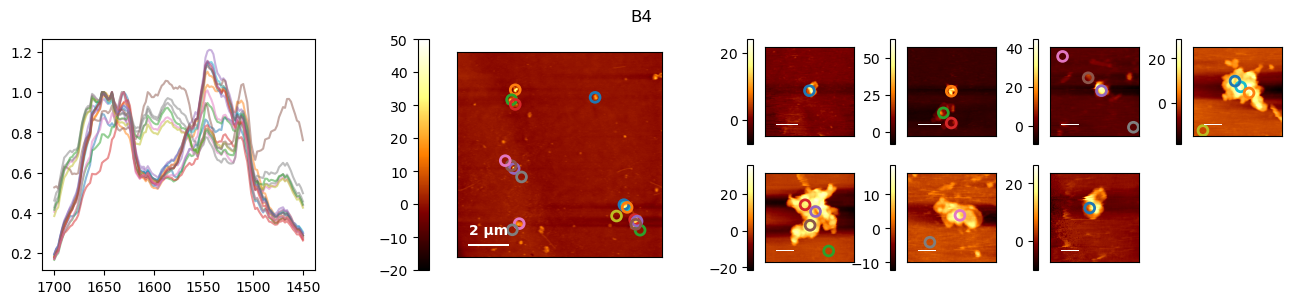

In [12]:
d = doc_b4
spectra = xr.concat(d.RenderedSpectra.values(), 'si').assign_coords(is_ib=('si', [True, False, True, False, True, False, False, False, False, True, True, True, False, True, True, True, True, False]))
spectra = aptwrapper.savgol(spectra)
spectra = spectra / spectra.sel(v=slice(1600,1700)).max('v')
s_ib = spectra.sel(v=slice(1450,1700))#.isel(si=spectra.is_ib==True)
plot_spectra(s_ib, d.HeightMaps['Height 2'], [d.HeightMaps[f'Height {i}'] for i in range(3,10)])
plt.suptitle('B4')
spectra

Text(0.5, 0.98, 'H4B')

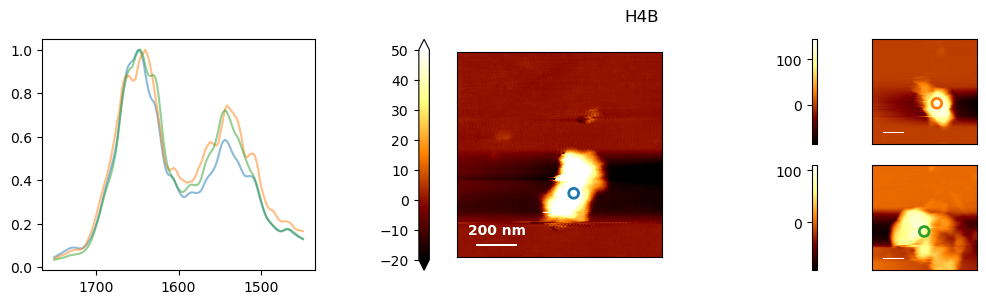

In [13]:
d = doc_h4b
spectra = xr.concat(d.RenderedSpectra.values(), 'si').assign_coords(is_ib=('si', [False, True, True, False, True, False]))
spectra = aptwrapper.savgol(spectra)
spectra = spectra / spectra.sel(v=slice(1600,1700)).max('v')
s_ib = spectra.sel(v=slice(1450,1750)).isel(si=spectra.is_ib==True)
plot_spectra(s_ib, d.HeightMaps['Height 1'], [d.HeightMaps[f'Height {i}'] for i in range(2,4)])
plt.suptitle('H4B')

Text(0.5, 0.98, 'R4')

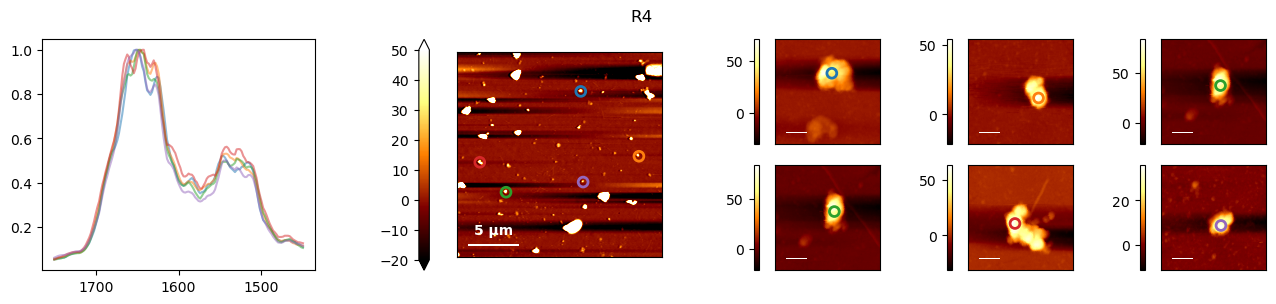

In [14]:
d = doc_r4
spectra = xr.concat(d.RenderedSpectra.values(), 'si').assign_coords(is_ib=('si', [True, False, True, False, True, False, True, False, True, False]))
spectra = aptwrapper.savgol(spectra)
spectra = spectra / spectra.sel(v=slice(1600,1700)).max('v')
s_ib = spectra.sel(v=slice(1450,1750)).isel(si=spectra.is_ib==True)
plot_spectra(s_ib, d.HeightMaps['Height 2'], [d.HeightMaps[f'Height {i}'] for i in range(3, 9) ])
plt.suptitle('R4')

['Height 2', 'Height 2 (Flatten)', 'Height 3', 'Height 4', 'Height 5', 'Height 6', 'Height 7', 'Height 8', 'Height 9', 'Height 10', 'Height 11', 'Height 11 (Flatten)']


Text(0.5, 0.98, 'B7')

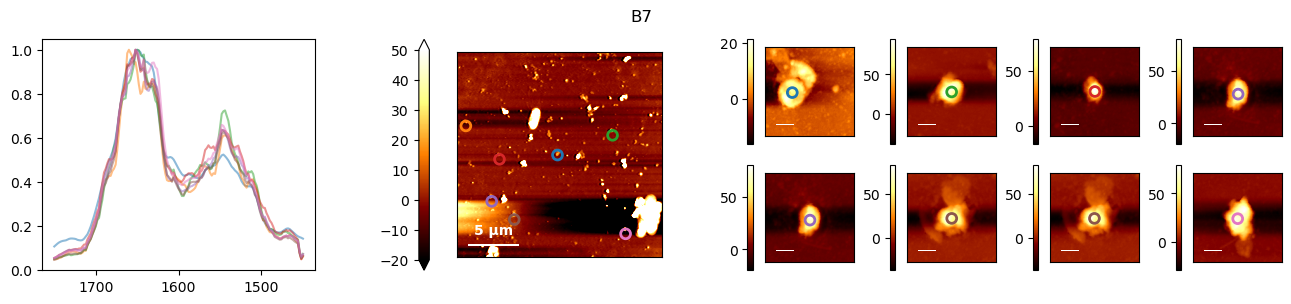

In [15]:
d = doc_b7
print(list(k for k in d.HeightMaps.keys() if k.startswith('Height')))
spectra = xr.concat(d.RenderedSpectra.values(), 'si').assign_coords(is_ib=('si', [True, False, True, False, True, False, True, False, True, False, True, False, True, False]))
spectra = aptwrapper.savgol(spectra)
spectra = spectra / spectra.sel(v=slice(1600,1700)).max('v')
s_ib = spectra.sel(v=slice(1450,1750)).isel(si=spectra.is_ib==True)
plot_spectra(s_ib, d.HeightMaps['Height 2'], [d.HeightMaps[f'Height {i}'] for i in range(3, 11) ])
plt.suptitle('B7')

['Height 2', 'Height 2 (Flatten)', 'Height 3', 'Height 4', 'Height 5', 'Height 6', 'Height 7', 'Height 8', 'Height 9', 'Height 10', 'Height 11', 'Height 12']


<xarray.Dataset>
Dimensions:              (si: 13, v: 175)
Coordinates:
    Label                (si) <U11 'Spectrum 1' 'Spectrum 2' ... 'Spectrum 14'
    Location.X           (si) float64 43.44 43.47 32.92 ... 34.01 45.57 45.87
    Location.Y           (si) float64 -3.698e+03 -3.698e+03 ... -3.703e+03
    PulseRate            (si) float64 854.3 854.4 853.2 ... 853.2 856.3 865.0
    TimeStamp            (si) datetime64[ns] 2023-10-05T11:16:13.959209200 .....
    AFMMode              <U7 'Contact'
    AttenuationBase64    float64 0.0137
    BackgroundFileName   <U68 'C:\\Users\\nanoIR\\Desktop\\DATA\\Wouter\\2023...
    BackgroundOption     <U6 'Normal'
    Polarization         <U2 '90'
  * v                    (v) float64 1.444e+03 1.446e+03 ... 1.79e+03 1.792e+03
    is_ib                (si) bool True False True False ... False True False
Dimensions without coordinates: si
Data variables:
    IR Phase (Deg)       (si, v) float64 0.9794 0.8237 0.7739 ... 0.5274 0.4175
    PLL Frequency (kHz)  (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    IR Amplitude (mV)    (si, v) float64 0.5678 0.3063 0.1481 ... 0.078 0.07743
    Attenuation          (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Background           (si, v) float64 0.1691 0.4233 0.5754 ... 0.1168 0.09573

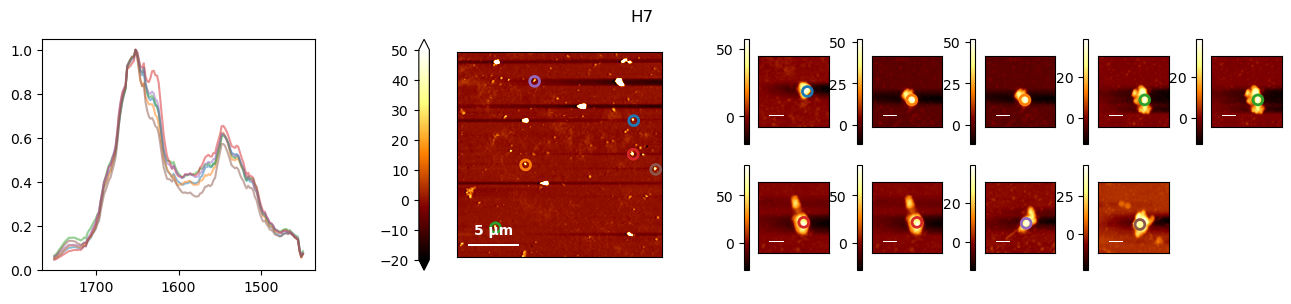

In [16]:
d = doc_h7
print(list(k for k in d.HeightMaps.keys() if k.startswith('Height')))
spectra = xr.concat(d.RenderedSpectra.values(), 'si').assign_coords(is_ib=('si', [True, False, True, False, True, False, True, False, True, False, False, True, False]))
spectra = aptwrapper.savgol(spectra)
spectra = spectra / spectra.sel(v=slice(1600,1700)).max('v')
s_ib = spectra.sel(v=slice(1450,1750)).isel(si=spectra.is_ib==True)
plot_spectra(s_ib, d.HeightMaps['Height 2'], [d.HeightMaps[f'Height {i}'] for i in range(3, 12) ])
plt.suptitle('H7')
spectra

['Height 2', 'Height 2 (Flatten)', 'Height 3', 'Height 4', 'Height 5', 'Height 6', 'Height 7', 'Height 8']


<xarray.Dataset>
Dimensions:              (si: 10, v: 175)
Coordinates:
    Label                (si) <U11 'Spectrum 1' 'Spectrum 2' ... 'Spectrum 11'
    Location.X           (si) float64 -424.2 -424.0 -411.7 ... -415.5 -415.2
    Location.Y           (si) float64 -2.393e+03 -2.393e+03 ... -2.398e+03
    PulseRate            (si) float64 854.9 875.0 851.7 ... 874.4 854.1 865.1
    TimeStamp            (si) datetime64[ns] 2023-10-05T13:15:28.913848200 .....
    AFMMode              <U7 'Contact'
    AttenuationBase64    float64 0.0137
    BackgroundFileName   <U68 'C:\\Users\\nanoIR\\Desktop\\DATA\\Wouter\\2023...
    BackgroundOption     <U6 'Normal'
    Polarization         <U2 '90'
  * v                    (v) float64 1.444e+03 1.446e+03 ... 1.79e+03 1.792e+03
    is_ib                (si) bool True False True False ... False True False
Dimensions without coordinates: si
Data variables:
    IR Phase (Deg)       (si, v) float64 0.9328 0.843 0.775 ... 0.3794 0.3378
    PLL Frequency (kHz)  (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    IR Amplitude (mV)    (si, v) float64 0.1165 0.1218 0.1256 ... 0.1271 0.1602
    Attenuation          (si, v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Background           (si, v) float64 0.5742 0.5873 ... 0.08571 0.06501

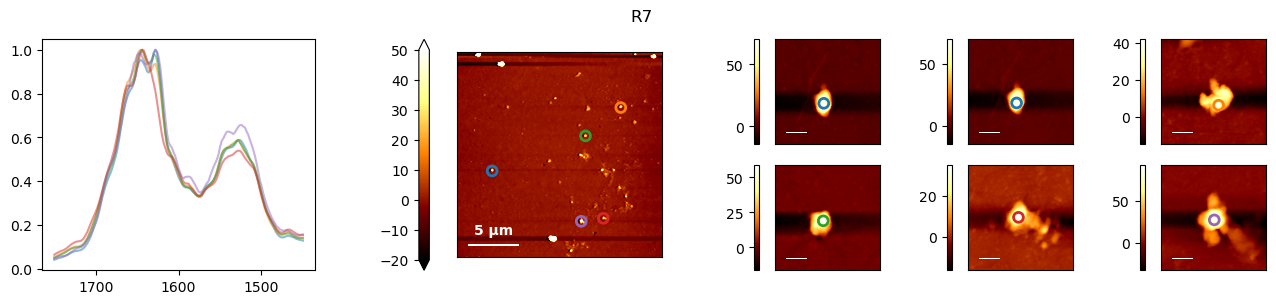

In [17]:
d = doc_r7
print(list(k for k in d.HeightMaps.keys() if k.startswith('Height')))
spectra = xr.concat(d.RenderedSpectra.values(), 'si').assign_coords(is_ib=('si', [True, False, True, False, True, False, True, False, True, False]))
spectra = aptwrapper.savgol(spectra)
spectra = spectra / spectra.sel(v=slice(1600,1700)).max('v')
s_ib = spectra.sel(v=slice(1450,1750)).isel(si=spectra.is_ib==True)
plot_spectra(s_ib, d.HeightMaps['Height 2'], [d.HeightMaps[f'Height {i}'] for i in range(3, 9) ])
plt.suptitle('R7')
spectra

### IB Heterogeneity

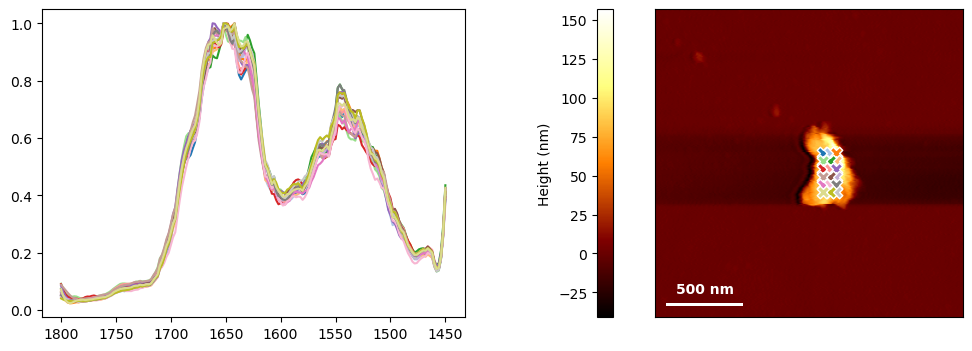

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
aptwrapper.plot_map(doc_r1.HeightMaps['Height 10'], ax=ax[1])

c = sns.color_palette('tab20', 18)

for i in range(17,35):
    s = doc_r1.RenderedSpectra[f'Spectrum {i}']
    s = aptwrapper.savgol(s)
    s = s / s.sel(v=slice(1600,1700)).max('v')
    aptwrapper.mark_location(s, ax=ax[1], color=c[i-17])
    ax[0].plot(s.v, s['IR Amplitude (mV)'], alpha=1, color=c[i-17])

ax[0].invert_xaxis()
# ax[0].set(xlim=(1700,1600), ylim=(.8,1))

## Putting it together

In [19]:
spectra_metadata = [
    {
        'file': './2023-09-15 AFM-IR/230230919_b1.axz',
        'condition': 'B',
        'replicate': 1,
        'spectra_ib': [1, 3, #5 very small obj, 
                       7, 9, #11 not very good spectrum
                       13],
        'spectra_au': [#2 very different from the others, 
                       4, 6, 8, 10, 12, 14],
    }, {
        # Spec 19 gave very low signal which sometimes messes with normalisation
        'file': './2023-09-15 AFM-IR/230230915_h1.axz',
        'condition': 'H',
        'replicate': 1,
        'spectra_ib': [3, 5, 7, 9, 11, 13, 15, 17, 21],
        'spectra_au': [4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
    }, {
        'file': './2023-09-15 AFM-IR/230230918_r1.axz',
        'condition': 'R',
        'replicate': 1,
        'spectra_ib': [1, 3, 5, 9, 11, 13, 
                       15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,32,33,34],
        'spectra_au': [2, 4, 6, 10, 12, 14, 16],
    },
    # Disregarding B4 because there are no decent au spectra
    # Disregarding H4A because the software kind of crashed
    {
        'file': './2023-09-15 AFM-IR/20231004_h4_sessionB.axz',
        'condition': 'H',
        'replicate': 4,
        'spectra_ib': [2, 3, 5],
        'spectra_au': [1, 4], # deleting spec6
    }, {
        'file': './2023-09-15 AFM-IR/20231004_r4.axz',
        'condition': 'R',
        'replicate': 4,
        'spectra_ib': [1, 3, 5, 7, 9],
        'spectra_au': [2, 4, 6, 8, 10],
    }, {
        'file': './2023-09-15 AFM-IR/20231005_b7.axz',
        'condition': 'B',
        'replicate': 7,
        'spectra_ib': [3, 5, 7, 9, 11, 13],
        'spectra_au': [4, 6, 8, 10, 12, 14],
    }, {
        'file': './2023-09-15 AFM-IR/20231005_h7.axz',
        'condition': 'H',
        'replicate': 7,
        'spectra_ib': [1, 3+1, 5+1, 7+1, 9+1, 12+1],
        'spectra_au': [2, 4+1, 6+1, 8+1, 10+1, 11+1, 13+1],
    }, {
        'file': './2023-09-15 AFM-IR/20231005_r7.axz',
        'condition': 'R',
        'replicate': 7,
        'spectra_ib': [1, 3, 5, 7, 9+1],
        'spectra_au': [2, 4, 6, 8+1, 10+1],
    }
]

Text(0.5, 0.98, 'Raw data')

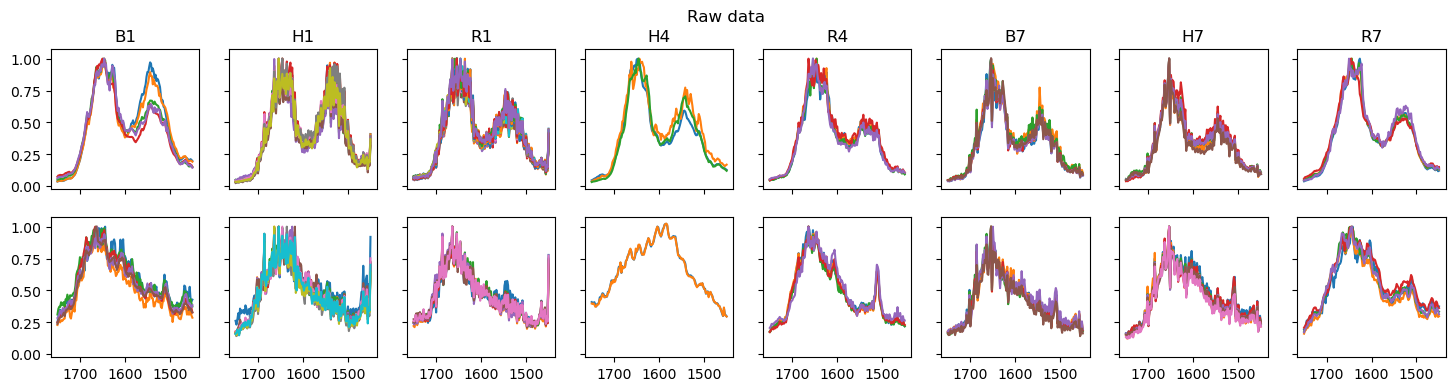

In [20]:
def read_spectra_metadata(datasets):
    dataset_xr = []
    for dataset in datasets:
        doc = aptwrapper.read(dataset['file'])
        spec_ib = [doc.RenderedSpectra[f'Spectrum {i}'] for i in dataset['spectra_ib']]
        spec_au = [doc.RenderedSpectra[f'Spectrum {i}'] for i in dataset['spectra_au']]
        dataset_xr = dataset_xr + [
            xr.concat(spec_ib+spec_au, dim='si').assign_coords(
                condition=dataset['condition'],
                replicate=dataset['replicate'],
                sample_name=dataset['condition'] + str(dataset['replicate']),
                is_ib = ('si', [True] * len(spec_ib) + [False] * len(spec_au))
        )] 

    return xr.concat(dataset_xr, dim='si')


spectra = read_spectra_metadata(spectra_metadata)['IR Amplitude (mV)']
fig, ax = plt.subplots(2, len(np.unique(spectra.sample_name)),
                       sharex=True, sharey=True, figsize=(18, 4))

for i, sample_name in enumerate(pd.unique(spectra.sample_name)):
    for s in spectra.isel(si=spectra.sample_name==sample_name):
        stype = s.is_ib.item()
        a = ax[0 if stype else 1, i]
        s = s.sel(v=slice(1450,1750))
        a.plot(s.v, s/s.sel(v=slice(1600,1700)).max('v'))
    ax[0, i].set_title(sample_name)
    ax[1, i].set_ylabel('')

ax[0,0].invert_xaxis()
for a in ax.ravel():
    a.set(ylabel='', xlabel='')

plt.suptitle("Raw data")

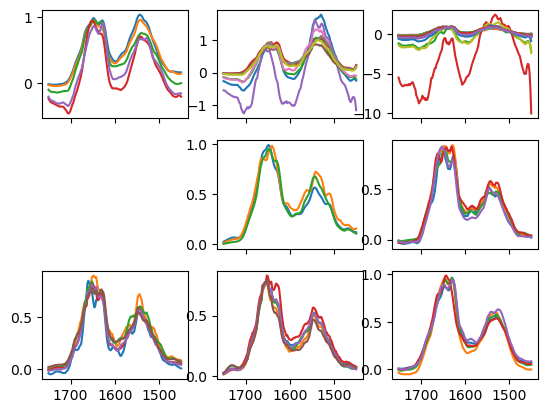

In [21]:
x = read_spectra_metadata(spectra_metadata)['IR Amplitude (mV)']
x = x.groupby('sample_name').apply(lambda x: x-x[~x.is_ib].mean('si'))
x = x[x.is_ib]
x = x.sel(v=slice(1450,1750))
x = x/x.sel(v=slice(1600,1700)).max('v')
x = aptwrapper.savgol(x)

fig, ax = plt.subplots(3, 3, sharex=True, sharey=False)
for i, sample_name in enumerate(['B1', 'H1', 'R1', None, 'H4', 'R4', 'B7', 'H7', 'R7']):
    if sample_name is None: ax.ravel()[i].axis('off'); continue
    s = x[x.sample_name == sample_name]
    for si in s: 
        ax.ravel()[i].plot(s.v, si)

ax[0,0].invert_xaxis()


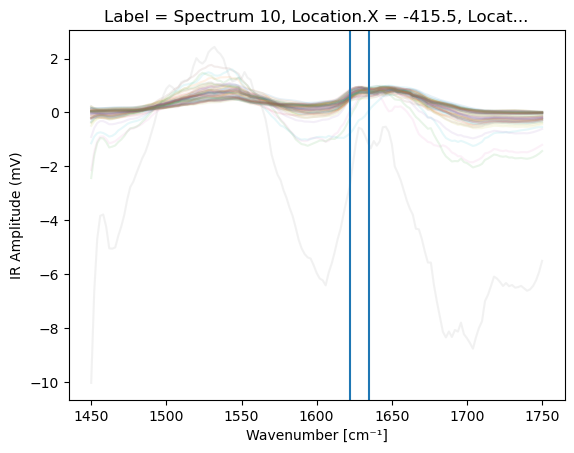

In [22]:
for si in x:
    si.plot(alpha=.1)

plt.axvline(1622)
plt.axvline(1635)

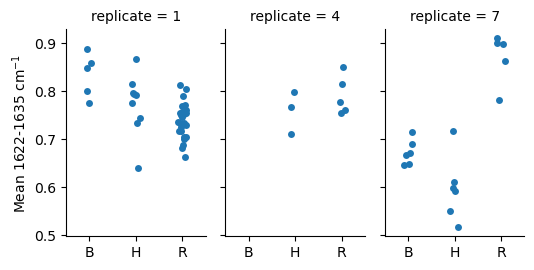

In [23]:
x = read_spectra_metadata(spectra_metadata)['IR Amplitude (mV)']
# x = x.groupby('sample_name').apply(lambda x: x-x[~x.is_ib].mean('si'))
x = x[x.is_ib]
x = x.sel(v=slice(1450,1750))
x = x/x.sel(v=slice(1600,1700)).max('v')
x = aptwrapper.savgol(x)

g = sns.catplot(
    x[(x.sel(v=slice(1600,1700))>0).all('v')].sel(v=slice(1622,1635)).mean('v').to_dataframe(name='beta_signal'),
    x='condition', y='beta_signal', col='replicate',
    height=3, aspect=.6
)
g.set_xlabels('')
g.set_ylabels('Mean 1622-1635 cm$^{-1}$')

In [24]:
# x = read_spectra_metadata(spectra_metadata)['IR Amplitude (mV)']
# x_ib = x[x.is_ib]
# norm_factors = aptwrapper.savgol(x_ib, 30).sel(v=slice(1600,1700)).max('v')
# x_ib_norm = x_ib/norm_factors
# x_ib_unpeaked = x_ib_norm*(1-x_au_peaks/x_au_au)#/x_au_au

# fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
# for i, sample_name in enumerate(['B1', 'H1', 'R1', None, 'H4', 'R4', 'B7', 'H7', 'R7']):
#     if sample_name is None: ax.ravel()[i].axis('off'); continue
#     s = x_ib_unpeaked[x_ib_unpeaked.sample_name == sample_name]
#     for si in s: 
#         ax.ravel()[i].plot(s.v, si)

# ax[0,0].invert_xaxis()

# g = sns.catplot(
#     x_ib_unpeaked[(x_ib_unpeaked.sel(v=slice(1600,1700))>0).all('v')].sel(v=slice(1622,1635)).mean('v').to_dataframe(name='beta_signal'),
#     x='condition', y='beta_signal', col='replicate',
#     height=3, aspect=.6
# )
# g.set_xlabels('')
# g.set_ylabels('Mean 1622-1635 cm$^{-1}$')

Text(0.5, 0.98, 'Raw data (normalised)')

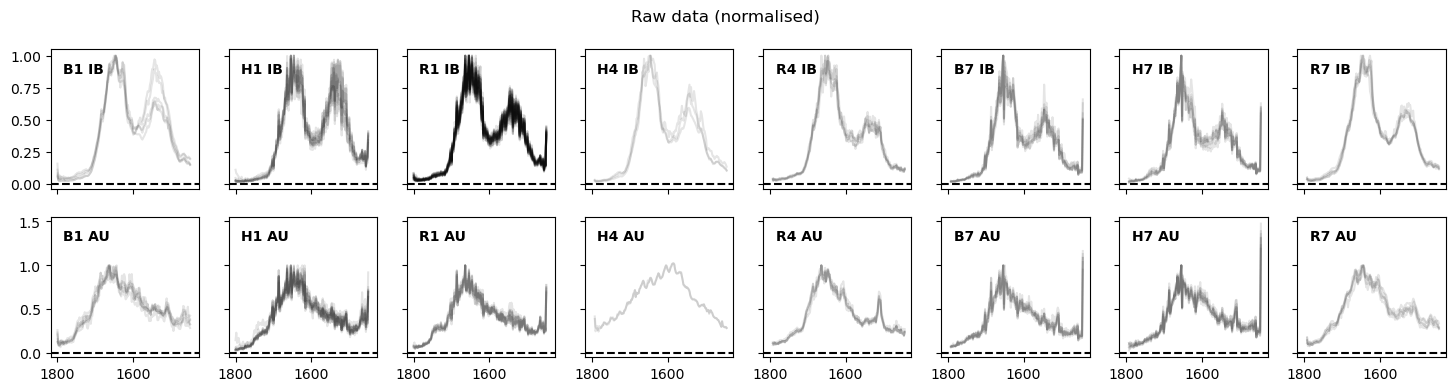

In [25]:
def plot_spectra(x, sharex=True, sharey='row'):
    samples = pd.unique(x.sample_name)
    locations = pd.unique(x.is_ib)

    fig, ax = plt.subplots(len(locations), len(samples), squeeze=False, 
                           sharex=sharex, sharey=sharey, figsize=(18, 2*len(locations)))
    
    for i, sample_name in enumerate(samples):
        for j, loc in enumerate(locations):
            s = x[(x.sample_name == sample_name) & (x.is_ib == loc)]
            for si in s: 
                ax[j,i].plot(s.v, si, alpha=.1, c='k')
            aptwrapper.annotate(ax[j,i], f'{sample_name} {"IB" if loc else "AU"}', c='k')
    ax[0,0].invert_xaxis()

    for a in ax.ravel(): a.axhline(0, ls='--', c='k')

spectra = read_spectra_metadata(spectra_metadata)['IR Amplitude (mV)']
plot_spectra(spectra/spectra.sel(v=slice(1600,1700)).max('v'))
plt.suptitle('Raw data (normalised)')

(0.26, 1.74)

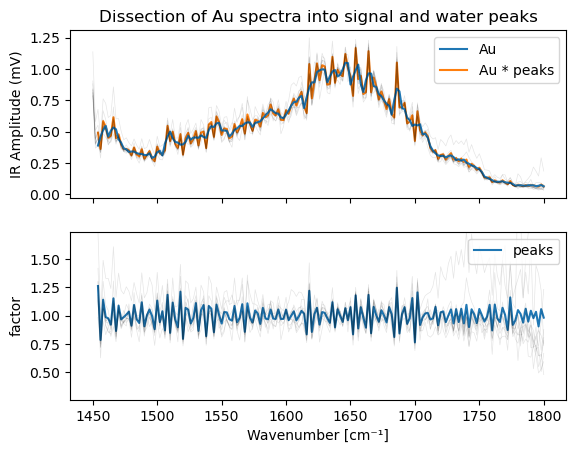

In [26]:
def get_correction_spectra(spectra_au_raw):
    # x_au_sg = aptwrapper.savgol(x_au, 11)
    norm_factors = aptwrapper.savgol(spectra_au_raw, 30).sel(v=slice(1600,1700)).max('v')
    spec_norm = spectra_au_raw/norm_factors
    spec_au = aptwrapper.savgol(spec_norm, 5).mean('si')
    spec_peaks = (spec_norm / spec_au).mean('si')

    return spec_au, spec_peaks

fig, ax = plt.subplots(2, sharex=True)

spectra = read_spectra_metadata(spectra_metadata)['IR Amplitude (mV)']
x = spectra[(spectra.sample_name=='H1') & ~spectra.is_ib]
spec_au, spec_peaks = get_correction_spectra(x)
spec_au.plot(label='Au', ax=ax[0])
(spec_au*spec_peaks).plot(label='Au * peaks', zorder=-1, ax=ax[0])
spec_peaks.plot(label='peaks', ax=ax[1])

for s in x:
    s = s/aptwrapper.savgol(s, 30).sel(v=slice(1600,1700)).max('v')
    s.plot(c='k', alpha=.1, lw=.5, ax=ax[0])
    (s/spec_au).plot(c='k', alpha=.1, lw=.5, ax=ax[1])

ax[0].legend()
ax[1].legend(loc='upper right')
ax[0].set_title('Dissection of Au spectra into signal and water peaks')
ax[1].set_title('')
ax[0].set_xlabel('')
ax[1].set_ylabel('factor')
ax[1].set_ylim(.26,1.74)

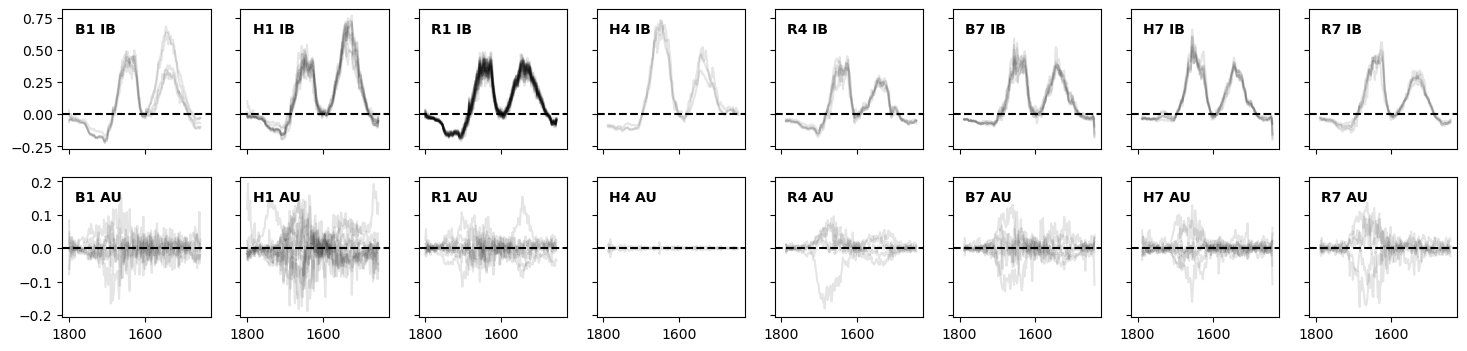

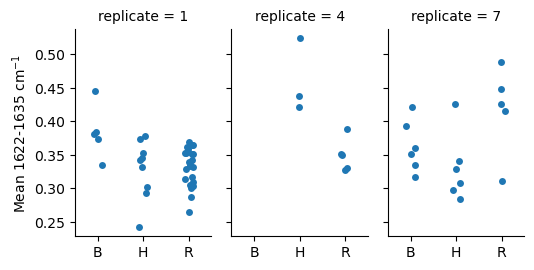

In [27]:
def process_spectra(spec_sample):
    spec_au, spec_peaks = get_correction_spectra(spec_sample[~spec_sample.is_ib])

    # Noramlise to amide 1 peak
    norms = aptwrapper.savgol(spec_sample, 30).sel(v=slice(1600,1700)).max('v')
    spec_sample = spec_sample / norms

    # Remove water peaks
    spec_sample = spec_sample / spec_peaks
    
    # Remove Au spectrum
    norm_sample = aptwrapper.savgol(spec_sample, 30).sel(v=slice(1595,1605)).mean('v')
    norm_au = aptwrapper.savgol(spec_au, 30).sel(v=slice(1595,1605)).mean('v')
    spec_sample = spec_sample - spec_au / norm_au * norm_sample
    
    return spec_sample

spectra = read_spectra_metadata(spectra_metadata)['IR Amplitude (mV)']
spectra = spectra.groupby('sample_name').apply(process_spectra)
plot_spectra(spectra)

g = sns.catplot(
    spectra[spectra.is_ib].sel(v=slice(1622,1635)).mean('v').to_dataframe(name='beta_signal'),
    x='condition', y='beta_signal', col='replicate',
    height=3, aspect=.6
)
g.set_xlabels('')
g.set_ylabels('Mean 1622-1635 cm$^{-1}$')

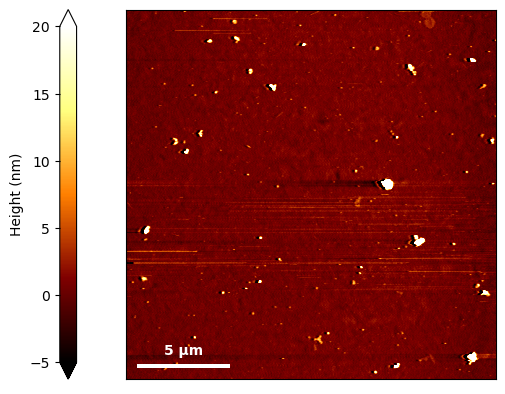

In [69]:
from scipy.optimize import curve_fit

# def subtract_plane(xarr, xorder=1, yorder=1, xyorder=0):
def subtract_plane(xarr, order=1, mask=None):
    def plane(xy, a, b, c):
        x, y = xy[:,0], xy[:,1]
        return a * x + b * y + c
    
    def parabola(xy, a, b, c, d, e, f):
        x, y = xy[:,0], xy[:,1]
        return a * x + b * y + c + d * x**2 + e * y**2 + f * x * y
    
    def fitter(xy, *args):
        x, y = xy[:,0], xy[:,1]

        offset = args[0]
        xcoeffs = args[1:1+xorder]
        ycoeffs = args[1+xorder:1+xorder+yorder]
        xycoeffs = args[1+xorder+yorder:]
        return (
            offset + 
            sum(np.power(x, i) * xcoeffs[i] for i in range(xorder)) +
            sum(np.power(y, i) * ycoeffs[i] for i in range(yorder)) +
            sum(np.power(x*y, i) * xycoeffs[i] for i in range(xyorder))
        )


    XY0 = np.hstack([
        xarr.X.values.reshape(-1,1),
        xarr.Y.values.reshape(-1,1)
    ])

    Z0 = xarr.values.reshape(-1)

    XY = XY0 if mask is None else XY0[mask.reshape(-1), :]
    Z = Z0 if mask is None else Z0[mask.reshape(-1)]

    # fn = fitter
    fn = {1: plane, 2: parabola}[order]
    popt, _ = curve_fit(fn, XY, Z)#, p0=[0] * (1 + xorder + yorder + xyorder))
    return xarr - fn(XY0, *popt).reshape(xarr.shape)

def flatten(hmap):
    hmap1 = aptwrapper.subtract_lines(hmap)
    mask = hmap1.data < 0
    hmap2 = aptwrapper.subtract_lines(hmap, mask=mask)
    return hmap2

doc = aptwrapper.read(spectra_metadata[1]['file'])
hmap = doc.HeightMaps['Height 3']
# aptwrapper.plot_map(hmap, vmax=20, vmin=-5, flatten=flatten)
aptwrapper.plot_map(hmap, flatten=flatten, vmax=20, vmin=-5)